In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import argparse , os , shutil , time

from fastai.transforms import *
from fastai.dataset import *
from fastai.fp16 import *
from fastai.conv_learner import *
from pathlib import *
import sys

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# import models
from datetime import datetime

# model_names = sorted(name for name in models.__dict__
#                      if name.islower() and not name.startswith("__")
#                      and callable(models.__dict__[name]))
# print(model_names)

In [3]:
def get_parser():
    parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
    parser.add_argument('data', metavar='DIR', help='path to dataset')
    parser.add_argument('--warmonly', action='store_true', help='Just 1 epoch of each size')
    parser.add_argument('--save-dir', type=str, default=Path.home()/'imagenet_training',
                        help='Directory to save logs and models.')
    # parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet18',
    #                     choices=model_names,
    #                     help='model architecture: ' +
    #                     ' | '.join(model_names) +
    #                     ' (default: resnet18)')
    parser.add_argument('-j', '--workers', default=8, type=int, metavar='N',
                        help='number of data loading workers (default: 4)')
    parser.add_argument('--epochs', default=45, type=int, metavar='N',
                        help='number of total epochs to run')
    parser.add_argument('-b', '--batch-size', default=192, type=int,
                        metavar='N', help='mini-batch size (default: 256)')
    parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--schedule', default='0,0.1,0.4,0.47,0.78,0.92,0.95,1', type=str,
                        help='Learning rate scheduler warmup -> lr -> upsize -> lr/10 -> upsize -> lr/100 -> lr/1000')
    parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
    parser.add_argument('--weight-decay', '--wd', default=1e-2, type=float,
                        metavar='W', help='weight decay (default: 1e-4)')
    parser.add_argument('--print-freq', '-p', default=50, type=int,
                        metavar='N', help='print frequency (default: 10)')
    parser.add_argument('--pretrained', dest='pretrained', action='store_true', help='use pre-trained model')
    parser.add_argument('--fp16', action='store_true', help='Run model fp16 mode.')
    parser.add_argument('--sz', default=224, type=int, help='Size of transformed image.')
    # parser.add_argument('--decay-int', default=30, type=int, help='Decay LR by 10 every decay-int epochs')
    parser.add_argument('--use-clr', type=str,
                        help='div,pct,max_mom,min_mom. Pass in a string delimited by commas. Ex: "20,2,0.95,0.85"')
    parser.add_argument('--loss-scale', type=float, default=1,
                        help='Loss scaling, positive power of 2 values can improve fp16 convergence.')
    parser.add_argument('--prof', dest='prof', action='store_true', help='Only run a few iters for profiling.')

    parser.add_argument('--distributed', action='store_true', help='Run distributed training')
    parser.add_argument('--world-size', default=-1, type=int, 
                        help='Number of gpus per machine. Param only needed for single machine training when using (faster) file sync')
    parser.add_argument('--dist-url', default='file://sync.file', type=str,
                        help='url used to set up distributed training')
    parser.add_argument('--dist-backend', default='nccl', type=str, help='distributed backend')
    parser.add_argument('--local_rank', default=0, type=int,
                        help='Used for multi-process training. Can either be manually set ' +
                        'or automatically set by using \'python -m multiproc\'.')
    return parser

In [4]:
def torch_loader(data_path, size, use_val_sampler=True, min_scale=0.08, max_scale=1.0, bs=192):
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'validation')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor_tfm = [transforms.ToTensor(), normalize]

    train_dataset = datasets.ImageFolder(
        traindir, transforms.Compose([
            transforms.RandomResizedCrop(size, scale=(min_scale, max_scale)),
            transforms.RandomHorizontalFlip(),
        ] + tensor_tfm))
    val_dataset = datasets.ImageFolder(
        valdir, transforms.Compose([
            transforms.Resize(int(size*1.14)),
            transforms.CenterCrop(size),
        ] + tensor_tfm))

    train_sampler = (torch.utils.data.distributed.DistributedSampler(train_dataset) if args.distributed else None)
    val_sampler = (torch.utils.data.distributed.DistributedSampler(val_dataset) if args.distributed and use_val_sampler else None)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False,
        num_workers=args.workers, pin_memory=True, sampler=val_sampler)

    data = ModelData(data_path, train_loader, val_loader)
    data.sz = size
    if train_sampler is not None: data.trn_sampler = train_sampler
    if val_sampler is not None: data.val_sampler = val_sampler
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self): return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break


def top5(output, target):
    """Computes the precision@k for the specified values of k"""
    top5 = 5
    batch_size = target.size(0)
    _, pred = output.topk(top5, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    correct_k = correct[:top5].view(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(1.0 / batch_size)

class ImagenetLoggingCallback(Callback):
    start_time = 0
    def __init__(self, save_path, print_every=50):
        super().__init__()
        self.save_path=save_path
        self.print_every=print_every
        self.start_time = datetime.now()
    def on_train_begin(self):
        self.batch = 0
        self.epoch = 0
        self.f = open(self.save_path, "a", 1)   
        self.log("epoch\thours\tAccuracy\ttop1Accuracy\ttop5Accuracy")
    def on_epoch_end(self, metrics):
        current_time = datetime.now()
        time_diff = current_time - self.start_time
        log_str = f'{self.epoch}\t{float(time_diff.total_seconds() / 3600.0)}\t{metrics[1]}\t{metrics[2]}\t{metrics[3]}'
        self.log(log_str)
        self.epoch += 1
    def on_batch_end(self, metrics):
        self.last_loss = metrics
        self.batch += 1
    def on_train_end(self): self.f.close()
    def log(self, string): self.f.write(string+"\n")

def save_args(name, save_dir):
    if (args.local_rank != 0) or not args.save_dir: return {}

    log_dir = f'{save_dir}/training_logs'
    os.makedirs(log_dir, exist_ok=True)
    return {
        'best_save_name': f'{name}_best_model',
        'callbacks': [
            ImagenetLoggingCallback(f'{log_dir}/{name}_log.txt', args.print_freq)
        ]
    }

def save_sched(sched, save_dir):
    if (args.local_rank != 0) or not args.save_dir: return {}
    log_dir = f'{save_dir}/training_logs'
    sched.save_path = log_dir
    sched.plot_loss()
    sched.plot_lr()

def update_model_dir(learner, base_dir):
    learner.tmp_path = f'{base_dir}/tmp'
    os.makedirs(learner.tmp_path, exist_ok=True)
    learner.models_path = f'{base_dir}/models'
    os.makedirs(learner.models_path, exist_ok=True)

def top_k(output, target, k=5):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.size(0)
    _, pred = output.topk(k, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(1.0 / batch_size)

def top1(output, target): return top_k(output, target, 1)
def top5(output, target): return top_k(output, target, 5)

In [5]:
cudnn.benchmark = True
args = get_parser().parse_args(['/home/paperspace/data/imagenet', '--fp16', '--loss-scale', '512'])
if args.local_rank > 0: sys.stdout = open(f'{args.save_dir}/GPU_{args.local_rank}.log', 'w')
if isinstance(args.schedule, str): args.schedule = [float(i) for i in args.schedule.split(',')]
print('Running script with args:', args)

Running script with args: Namespace(batch_size=192, data='/home/paperspace/data/imagenet', dist_backend='nccl', dist_url='file://sync.file', distributed=False, epochs=45, fp16=True, local_rank=0, loss_scale=512.0, lr=0.1, momentum=0.9, pretrained=False, print_freq=50, prof=False, save_dir=PosixPath('/home/paperspace/imagenet_training'), schedule=[0.0, 0.1, 0.4, 0.47, 0.78, 0.92, 0.95, 1.0], sz=224, use_clr=None, warmonly=False, weight_decay=0.01, workers=8, world_size=-1)


In [6]:
if args.distributed:
    torch.cuda.set_device(args.local_rank)
    dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url, world_size=args.world_size)
    assert(args.world_size == dist.get_world_size())

# if args.pretrained: model = models.__dict__[args.arch](pretrained=True)
# else:               model = models.__dict__[args.arch]()
# import resnet
from fastai.models import resnet

model = resnet.resnet50()

model = model.cuda()
if args.fp16: model = FP16(model) # Seeing if half precision works if we set it before DistributedDataParallel
if args.distributed: model = nn.parallel.DistributedDataParallel(model, device_ids=[args.local_rank], output_device=args.local_rank)

In [7]:
# data1 = torch_loader(f'{args.data}-sz/320', size=args.sz, bs=192) # AS Try this laters
data1 = torch_loader(args.data, size=args.sz, bs=192) # AS Try this laters
learner = Learner.from_model_data(model, data1)
learner.crit = F.cross_entropy
learner.metrics = [accuracy, top1, top5]
if args.fp16: learner.half()

In [8]:
learner.lr_find(wds=1e-2)

 16%|█▋        | 1092/6673 [05:43<29:15,  3.18it/s, loss=6.94]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 19%|█▊        | 1245/6673 [06:30<28:24,  3.19it/s, loss=6.93]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 26%|██▌       | 1730/6673 [08:57<25:36,  3.22it/s, loss=6.89]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 32%|███▏      | 2104/6673 [10:53<23:38,  3.22it/s, loss=6.88]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 32%|███▏      | 2130/6673 [11:00<23:29,  3.22it/s, loss=6.88]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 44%|████▎     | 2903/6673 [14:56<19:23,  3.24it/s, loss=6.85]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1835008 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 45%|████▍     | 2978/6673 [15:19<19:00,  3.24it/s, loss=6.82]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 81%|████████  | 5372/6673 [27:26<06:38,  3.26it/s, loss=6.89]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 37093376 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 39976960 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/pa

 93%|█████████▎| 6194/6673 [31:36<02:26,  3.27it/s, loss=6.91]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Process Process-7:
Process Process-10:
Process Process-5:
Process Process-12:
Process Process-2:
Process Process-4:
Process Process-8:
Traceback (most recent call last):
Process Process-16:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-1:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-6:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-11:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/paper

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 130, in pil_loader
    return img.convert('RGB')
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 147, in default_loader
    return pil_loader(path)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/

KeyboardInterrupt
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 130, in pil_loader
    return img.convert('RGB')
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
Process Process-15:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 879, in convert


Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-6b0752a6d199>", line 1, in <module>
    learner.lr_find(wds=1e-2)
  File "/home/paperspace/fastai/courses/dl2/fastai/learner.py", line 341, in lr_find
    self.fit_gen(self.model, self.data, layer_opt, 1, **kwargs)
  File "/home/paperspace/fastai/courses/dl2/fastai/learner.py", line 245, in fit_gen
    swa_eval_freq=swa_eval_freq, **kwargs)
  File "/home/paperspace/fastai/courses/dl2/fastai/model.py", line 162, in fit
    vals = validate(model_stepper, cur_data.val_dl, metrics, seq_first=seq_first)
  File "/home/paperspace/fastai/courses/dl2/fastai/model.py", line 238, in validate
    loss.append(to_np(l))
  File "/home/paperspace/fastai/courses/dl2/fastai/core.py", line 67, in to_np
    return v.cpu().numpy()
KeyboardInterrupt

During handlin

KeyboardInterrupt
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 879, in convert
    self.load()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 888, in convert
    return self.copy()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 1057, in copy
    return self._new(self.im.copy())
KeyboardInterrupt
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/ImageFile.py", line 231, in load
    n, err_code = decoder.decode(b)


KeyboardInterrupt: 

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/ImageFile.py", line 231, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt


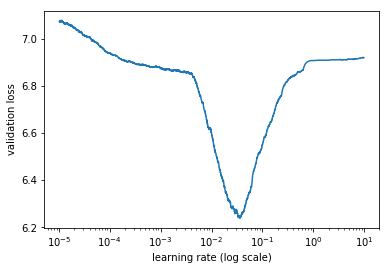

In [10]:
learner.sched.plot()

In [ ]:
from functools import partial

In [7]:
# data1 = torch_loader(f'{args.data}-sz/320', size=args.sz, bs=192) # AS Try this laters
data1 = torch_loader(args.data, size=args.sz, bs=192) # AS Try this laters
learner = Learner.from_model_data(model, data1)
learner.crit = F.cross_entropy
learner.metrics = [accuracy, top1, top5]
if args.fp16: learner.half()
learner.opt_fn = partial(optim.Adam, betas=(0.95,0.99))

In [8]:
learner.lr_find(wds=1e-3, start_lr=1e-8, end_lr=1e-1, use_wd_sched=True)

 15%|█▌        | 1013/6673 [05:05<28:26,  3.32it/s, loss=7.08]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1835008 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 20%|█▉        | 1331/6673 [06:41<26:52,  3.31it/s, loss=7.06]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 21%|██        | 1369/6673 [06:52<26:39,  3.32it/s, loss=7.05]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 23%|██▎       | 1541/6673 [07:43<25:43,  3.32it/s, loss=7.04]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 26%|██▌       | 1746/6673 [08:45<24:44,  3.32it/s, loss=7.02]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 43%|████▎     | 2863/6673 [14:22<19:08,  3.32it/s, loss=6.86]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 37093376 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 39976960 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/pa

 53%|█████▎    | 3518/6673 [17:39<15:50,  3.32it/s, loss=6.74]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 84%|████████▍ | 5598/6673 [28:14<05:25,  3.30it/s, loss=6.05]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 96%|█████████▋| 6439/6673 [32:27<01:10,  3.31it/s, loss=6.94]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Process Process-6:
Process Process-4:
Process Process-8:
Process Process-12:
Process Process-10:
Process Process-11:
Traceback (most recent call last):
Process Process-3:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
Process Process-1:
Process Process-7:
Process Process-2:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-16:
Process Process-9:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", l

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 101, in __getitem__
    sample = self.loader(path)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File 

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 879, in convert
    self.load()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/ImageFile.py", line 215, in load
    s = read(self.decodermaxblock)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 2557, in open
    prefix = fp.read(16)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/JpegImagePlugin.py", line 362, in load_read
    s = self.fp.read(read_bytes)
KeyboardInterrupt
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/ImageFile.py", line 231, in load
  

Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-182c9c719888>", line 1, in <module>
    learner.lr_find(wds=1e-3, start_lr=1e-8, end_lr=1e-1, use_wd_sched=True)
  File "/home/paperspace/fastai/courses/dl2/fastai/learner.py", line 341, in lr_find
    self.fit_gen(self.model, self.data, layer_opt, 1, **kwargs)
  File "/home/paperspace/fastai/courses/dl2/fastai/learner.py", line 245, in fit_gen
    swa_eval_freq=swa_eval_freq, **kwargs)
  File "/home/paperspace/fastai/courses/dl2/fastai/model.py", line 162, in fit
    vals = validate(model_stepper, cur_data.val_dl, metrics, seq_first=seq_first)
  File "/home/paperspace/fastai/courses/dl2/fastai/model.py", line 238, in validate
    loss.append(to_np(l))
  File "/home/paperspace/fastai/courses/dl2/fastai/core.py", line 67, in to_np
    return v.

KeyboardInterrupt: 

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 130, in pil_loader
    return img.convert('RGB')
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 879, in convert
    self.load()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/ImageFile.py", line 231, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt


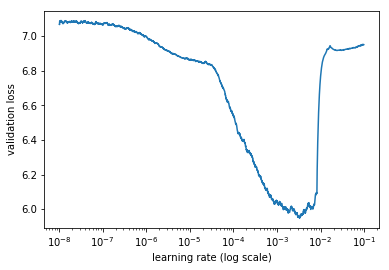

In [9]:
learner.sched.plot()

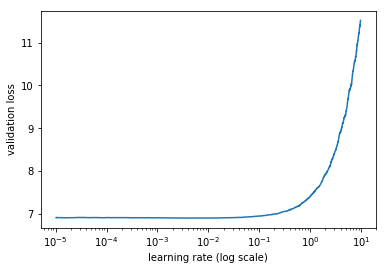

In [14]:
learner.sched.plot()

In [ ]:
if args.prof: args.epochs = 1
if args.use_clr: args.use_clr = tuple(map(float, args.use_clr.split(',')))
data0 = torch_loader(f'{args.data}-sz/160', size=128, bs=256)
data2 = torch_loader(args.data, size=288, bs=128, min_scale=0.5)
data3 = torch_loader(args.data, size=288, bs=128, min_scale=0.5, use_val_sampler=False)

update_model_dir(learner, args.save_dir)
sargs = save_args('first_run', args.save_dir)
# opt_fn = partial(optim.Adam, betas=(0.95,0.99))
# def_phase = {'opt_fn':opt_fn, 'wds':args.weight_decay}
# def_phase = {'opt_fn':opt_fn, 'wds':args.weight_decay}
opt_fn = partial(optim.SGD, momentum=args.momentum)
def_phase = {'opt_fn':opt_fn, 'wds':args.weight_decay}
lr = args.lr
# epoch_sched = [int(args.epochs*o+0.5) for o in (0, 0.1, 0.4, 0.47, 0.78, 0.92, 0.95, 1)]
epoch_sched = [int(args.epochs*o+0.5) for o in args.schedule]
# epoch_sched = [int(args.epochs*o+0.5) for o in (0, 0.3, 0.45, 0.52, 0.82, 0.92, 0.95, 1)]
num_epochs = [epoch_sched[n]-epoch_sched[n-1] for n in range(1,len(epoch_sched))]
if args.warmonly:
    data = [data0,data1]
    phases = [
        TrainingPhase(**def_phase, epochs=1, lr=(lr/100,lr), lr_decay=DecayType.LINEAR),
        TrainingPhase(**def_phase, epochs=1, lr=(lr,lr/100), lr_decay=DecayType.LINEAR)]
else:
    data = [data0,data0,data1,data1,data1,data2,data3]
    phases = [
        TrainingPhase(**def_phase, epochs=num_epochs[0], lr=(lr/20,lr), lr_decay=DecayType.LINEAR),
        TrainingPhase(**def_phase, epochs=num_epochs[1], lr=lr),
        TrainingPhase(**def_phase, epochs=num_epochs[2], lr=lr),
        TrainingPhase(**def_phase, epochs=num_epochs[3],   lr=lr/10),
        TrainingPhase(**def_phase, epochs=num_epochs[4], lr=lr/100),
        TrainingPhase(**def_phase, epochs=num_epochs[5], lr=lr/100),
        TrainingPhase(**def_phase, epochs=num_epochs[6],   lr=lr/1000)]

# getting out of memory. Maybe we need to collect memory?
import gc
gc.collect()
torch.cuda.empty_cache()

learner.fit_opt_sched(phases, data_list=data, loss_scale=args.loss_scale, **sargs)
save_sched(learner.sched, args.save_dir)

print('Finished!')